In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import torch.nn as nn
from torch import optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Data

In [39]:
class MyDataset(Dataset):
    def __init__(self, train=True, transform=None):
        # Get images file name
        self.gt_dir = 'datasets/five_k_expert_a_small/images/'
        self.img_dir = 'datasets/five_k_expert_a_small/image_lab/'
        self.imgs = os.listdir(self.gt_dir)
        
        # Train: first 4000 images, test: last 1000 images
        if train:
            self.imgs = self.imgs[:4000]
        else:
            self.imgs = self.imgs[4000:]

        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_fn = self.imgs[index]
        input_image = read_image(os.path.join(self.img_dir, img_fn)) / 255
        target_image = read_image(os.path.join(self.gt_dir, img_fn)) / 255
        
        input_image = self.transform(input_image)
        target_image = self.transform(target_image)

        return input_image.to(torch.float32), target_image.to(torch.float32)

mytransform = transforms.Compose([
    transforms.Resize((128, 128))
])

train_dataset = MyDataset(train=True, transform=mytransform)
test_dataset = MyDataset(train=False, transform=mytransform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Visual

In [3]:
# def show(image):
#     image = torch.permute(image, (1,2,0))
#     plt.imshow(image)
#     plt.axis("off")

# input_images, target_images = next(iter(train_dataloader))

# plt.figure(figsize=(20,20))
# for i in range(128):
#     plt.subplot(13, 10, i+1)
#     show(input_images[i])



In [4]:
# plt.figure(figsize=(20,20))
# for i in range(128):
#     plt.subplot(13, 10, i+1)
#     show(target_images[i])


# Model

In [4]:
class DoubleConvBlock(nn.Module):
    """double conv layers block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    """Downscale block: maxpool -> double conv block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class BridgeDown(nn.Module):
    """Downscale bottleneck block: maxpool -> conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class BridgeUP(nn.Module):
    """Downscale bottleneck block: conv -> transpose conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_up = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv_up(x)



class UpBlock(nn.Module):
    """Upscale block: double conv block -> transpose conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvBlock(in_channels * 2, in_channels)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)



    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return torch.relu(self.up(x))


class OutputBlock(nn.Module):
    """Output block: double conv block -> output conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Sequential(
            DoubleConvBlock(in_channels * 2, in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1))

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        return self.out_conv(x)


class deepWBnet(nn.Module):
    def __init__(self):
        super(deepWBnet, self).__init__()
        self.n_channels = 3
        self.encoder_inc = DoubleConvBlock(self.n_channels, 24)
        self.encoder_down1 = DownBlock(24, 48)
        self.encoder_down2 = DownBlock(48, 96)
        self.encoder_down3 = DownBlock(96, 192)
        self.encoder_bridge_down = BridgeDown(192, 384)
        self.decoder_bridge_up = BridgeUP(384, 192)
        self.decoder_up1 = UpBlock(192, 96)
        self.decoder_up2 = UpBlock(96, 48)
        self.decoder_up3 = UpBlock(48, 24)
        self.decoder_out = OutputBlock(24, self.n_channels)


    def forward(self, x):
        x1 = self.encoder_inc(x)
        x2 = self.encoder_down1(x1)
        x3 = self.encoder_down2(x2)
        x4 = self.encoder_down3(x3)
        x5 = self.encoder_bridge_down(x4)
        x = self.decoder_bridge_up(x5)
        x = self.decoder_up1(x, x4)
        x = self.decoder_up2(x, x3)
        x = self.decoder_up3(x, x2)
        out = self.decoder_out(x, x1)
        return out


def loss_fn(output, target):
    loss = torch.sum(torch.abs(output - target)) / output.size(0)
    return loss



net = deepWBnet()

lrdf=0.5
lrdp=25


optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, lrdp, gamma=lrdf, last_epoch=-1)

# Train

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f'runs/Generative_{timestamp}')
device = 'cuda'

net = net.to(device)

def train_one_epoch(epoch_index):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        if torch.isnan(outputs).any():
            raise Exception("Output is NaN")
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    writer.flush()
    return last_loss

def validation():
    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        running_loss += loss.item()
    avg_loss = running_loss / (i + 1)
    return avg_loss

for epoch_index in range(110):
    print('EPOCH {}:'.format(epoch_index))

    net.train(True)
    train_loss = train_one_epoch(epoch_index)
    net.train(False)
    val_loss = validation()

    print('LOSS train {} valid {}'.format(train_loss, val_loss))
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : train_loss, 'Validation' : val_loss },
                    epoch_index + 1)
    writer.flush()


EPOCH 0:
  batch 10 loss: 17951.380859375
  batch 20 loss: 17825.919140625
  batch 30 loss: 17071.3404296875
  batch 40 loss: 14554.284765625
  batch 50 loss: 10737.6708984375
  batch 60 loss: 9283.7931640625
LOSS train 9283.7931640625 valid 8843.016479492188
EPOCH 1:
  batch 10 loss: 8097.530029296875
  batch 20 loss: 7132.67998046875
  batch 30 loss: 6201.675732421875
  batch 40 loss: 5760.71064453125
  batch 50 loss: 5356.4400390625
  batch 60 loss: 4868.9294921875
LOSS train 4868.9294921875 valid 4751.966278076172
EPOCH 2:
  batch 10 loss: 4519.47119140625
  batch 20 loss: 4230.62138671875
  batch 30 loss: 4063.018896484375
  batch 40 loss: 3979.0231201171873
  batch 50 loss: 3857.7048828125
  batch 60 loss: 3715.39013671875
LOSS train 3715.39013671875 valid 3938.527359008789
EPOCH 3:
  batch 10 loss: 3835.004150390625
  batch 20 loss: 3696.4928466796873
  batch 30 loss: 3709.2022705078125
  batch 40 loss: 3497.0962890625
  batch 50 loss: 3527.231494140625
  batch 60 loss: 3501.427

In [7]:
model_path = 'checkpoints/model_{}.pth'.format(timestamp)
torch.save(net.state_dict(), model_path)
print("Saved " + model_path)

Saved checkpoints/model_20220908_102925.pth


# Inference

In [5]:
net = deepWBnet()
net.load_state_dict(torch.load("checkpoints/model_20220908_102925.pth"))
net.eval()

deepWBnet(
  (encoder_inc): DoubleConvBlock(
    (double_conv): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (encoder_down1): DownBlock(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (encoder_down2): DownBlock(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (double_conv): Sequential(
          (0): Conv2d

## Show a batch output of U-Net model

In [ ]:
with torch.no_grad():
    inputs, targets = next(iter(test_dataloader))
    outputs = net(inputs)


for i in range(len(inputs)):
    input = torch.permute(inputs[i], (1,2,0))
    target = torch.permute(targets[i], (1,2,0))
    output = torch.permute(outputs[i], (1,2,0))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1,3,1), plt.imshow(input), plt.title("Input"), plt.axis("off")
    plt.subplot(1,3,2), plt.imshow(target), plt.title("Target"), plt.axis("off")
    plt.subplot(1,3,3), plt.imshow(output), plt.title("Output"), plt.axis("off")
    plt.show()



## Inference big image

In [61]:
from sklearn.linear_model import LinearRegression

def kernelP(I):
    """ Kernel function: kernel(r, g, b) -> (r,g,b,rg,rb,gb,r^2,g^2,b^2,rgb,1)
        Ref: Hong, et al., "A study of digital camera colorimetric characterization
         based on polynomial modeling." Color Research & Application, 2001. """
    return (np.transpose((I[:, 0], I[:, 1], I[:, 2], I[:, 0] * I[:, 1], I[:, 0] * I[:, 2],
                          I[:, 1] * I[:, 2], I[:, 0] * I[:, 0], I[:, 1] * I[:, 1],
                          I[:, 2] * I[:, 2], I[:, 0] * I[:, 1] * I[:, 2],
                          np.repeat(1, np.shape(I)[0]))))


def get_mapping_func(image1, image2):
    """ Computes the polynomial mapping """
    image1 = np.reshape(image1, [-1, 3])
    image2 = np.reshape(image2, [-1, 3])
    m = LinearRegression().fit(kernelP(image1), image2)
    return m


def apply_mapping_func(image, m):
    """ Applies the polynomial mapping """
    sz = image.shape
    image = np.reshape(image, [-1, 3])
    result = m.predict(kernelP(image))
    result = np.reshape(result, [sz[0], sz[1], sz[2]])
    return result

def outOfGamutClipping(I):
    """ Clips out-of-gamut pixels. """
    I[I > 1] = 1  # any pixel is higher than 1, clip it to 1
    I[I < 0] = 0  # any pixel is below 0, clip it to 0
    return I

def infer(image):
    with torch.no_grad():
        input = torch.from_numpy(image)
        input = input.permute((2,0,1))
        input = mytransform(input)
        image1 = input.permute((1,2,0)).numpy()
        input = input.to(torch.float32)
        input = input.unsqueeze(0)
        output = net(input)[0]
    output = output.permute((1,2,0)).numpy()
    mapping_func = get_mapping_func(image1, output)
    return outOfGamutClipping(apply_mapping_func(image, mapping_func))

In [72]:
from skimage.io import imread

def infer_and_show(img_path):
    image = imread(img_path) / 255
    out_image = infer(image)

    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1), plt.imshow(image), plt.title("Input")
    plt.subplot(1,2,2), plt.imshow(out_image), plt.title("Output")
    plt.show()


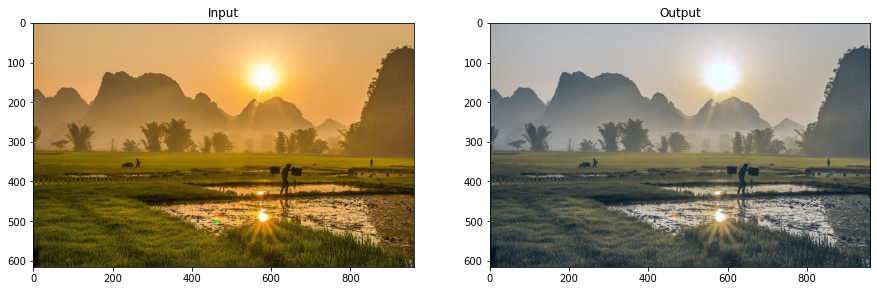

In [73]:
infer_and_show('images/landscape-4175978_960_720.jpg')

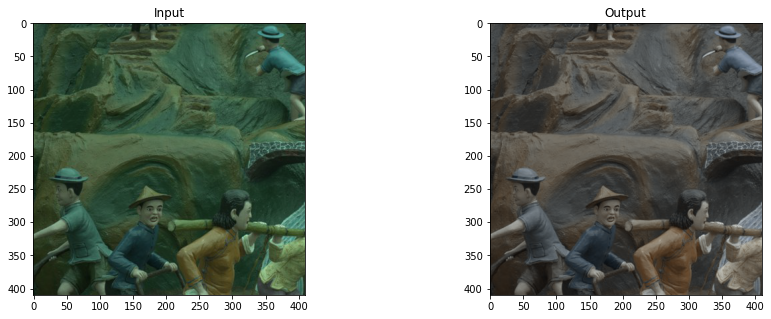

In [74]:
infer_and_show('images/test_image.png')

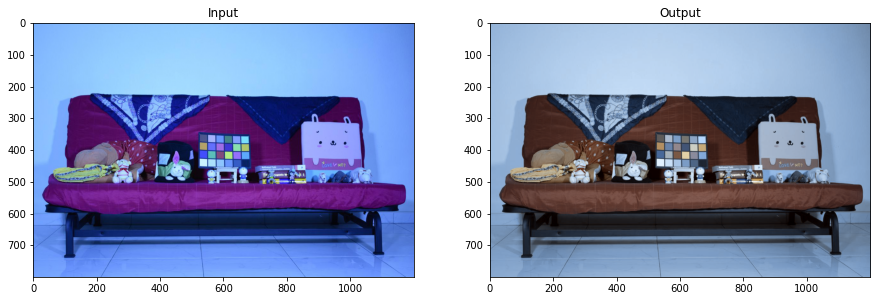

In [75]:
infer_and_show('images/NikonD5200_Indoor_Scene_18_6500_T_V.jpg')

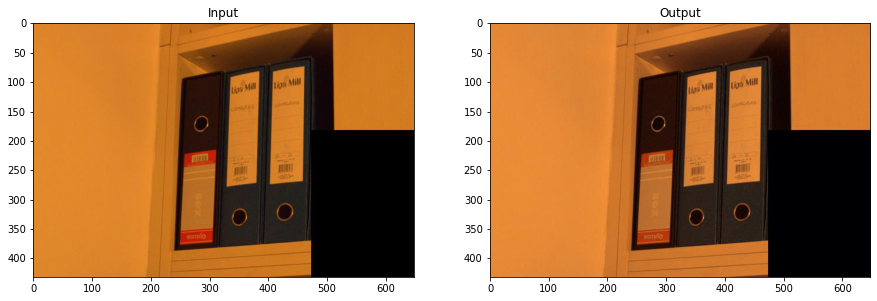

In [76]:
infer_and_show('images/test_00_0010.jpg')

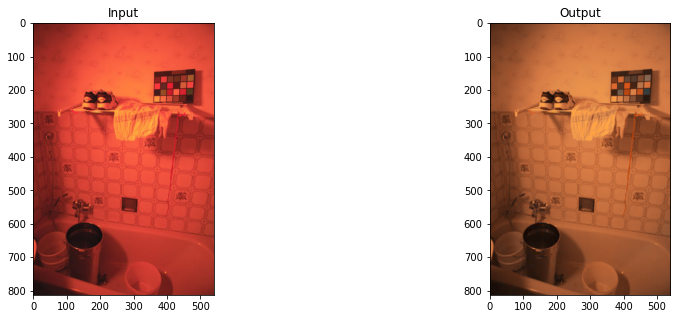

In [77]:
infer_and_show('images/8D5U5571_S_L.jpg')

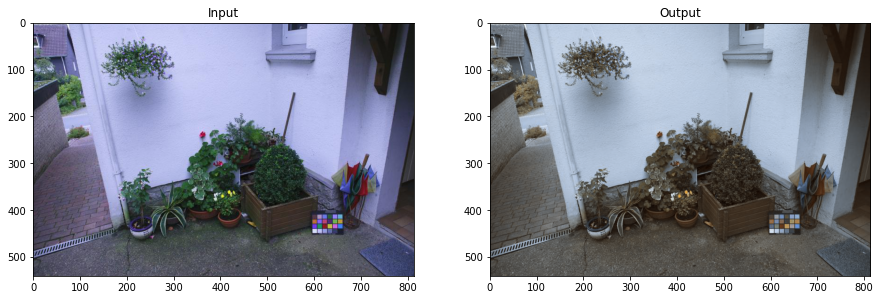

In [78]:
infer_and_show('images/8D5U5563_F_P.jpg')

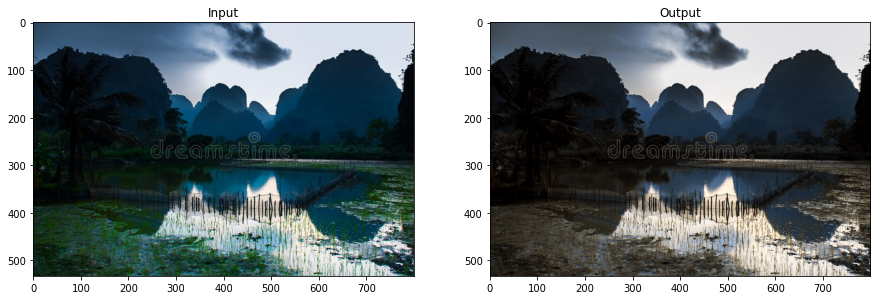

In [79]:
infer_and_show('images/beautiful-lanscape-lake-river-stunning-hills-trang-ninh-binh-vietnam-beautiful-lanscape-lake-river-125535813.jpg')